In [2]:
import os
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense,Activation
import numpy as geek
import soundfile as sf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten,Conv2D,MaxPooling2D,GRU, Input
from tensorflow.keras.layers import BatchNormalization, Dropout
from matplotlib import pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense
import numpy as np
import librosa
import os
import itertools
from keras.layers import Layer
from keras import backend as K 
import tensorflow.keras.backend as K
import librosa
from tensorflow.keras.utils import Sequence
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.metrics import BinaryAccuracy
import pickle
import random
from itertools import combinations

## **Part 1**

**Loading the MNIST dataset**

In [5]:
  mnist = tf.keras.datasets.mnist
  (xtrain, ytrain), (xtest,ytest) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
xtrain.shape, xtest.shape

((60000, 28, 28), (10000, 28, 28))

**Reshaping**

In [7]:
xtrain = np.reshape(xtrain, [-1, 784])
xtest = np.reshape(xtest, [-1, 784])
xtrain, xtest = xtrain/255, xtest/255

In [ ]:
xtrain.shape, xtest.shape

((60000, 784), (10000, 784))

In [ ]:
ytest

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

**Creating the baseline model**

In [8]:
initializer = tf.keras.initializers.HeNormal()
baseline = Sequential()
baseline.add(Dense(1024, input_dim=784,kernel_initializer=initializer))
baseline.add(Activation('relu'))
baseline.add(Dense(1024,kernel_initializer=initializer))
baseline.add(Activation('relu'))
baseline.add(Dense(1024,kernel_initializer=initializer))
baseline.add(Activation('relu'))
baseline.add(Dense(1024,kernel_initializer=initializer))
baseline.add(Activation('relu'))
baseline.add(Dense(1024,kernel_initializer=initializer))
baseline.add(Activation('relu'))
baseline.add(Dense(10))
baseline.add(Activation('softmax'))

In [9]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              803840    
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 activation_1 (Activation)   (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1

**Compiling and Running the model on train set**

In [10]:
baseline.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
baseline.fit(xtrain,ytrain,epochs=15)

Epoch 1/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2472 - accuracy: 0.9320
Epoch 2/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1290 - accuracy: 0.9670
Epoch 3/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0998 - accuracy: 0.9748
Epoch 4/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0780 - accuracy: 0.9806
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0682 - accuracy: 0.9823
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0619 - accuracy: 0.9845
Epoch 7/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0515 - accuracy: 0.9871
Epoch 8/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0470 - accuracy: 0.9886
Epoch 9/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0427 - accuracy: 0.9895
Epoch 10/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.036

**As you can see the test accuracy reaches more than 98 % for the baseline model.**

In [12]:
baseline.evaluate(xtest,ytest)

313/313 [==============================] - 1s 3ms/step - loss: 0.1376 - accuracy: 0.9838


[0.13764652609825134, 0.9837999939918518]

**SVD Compression**

In [13]:
baseline.layers[0].get_weights()

[array([[-0.02895092, -0.07892667, -0.00089907, ...,  0.06180728,
          0.03494838, -0.10513128],
        [ 0.0217425 , -0.06890235,  0.0348471 , ...,  0.01484497,
         -0.08463725,  0.09094539],
        [ 0.0014361 ,  0.10810334,  0.03916721, ...,  0.02207753,
         -0.07862034,  0.04667902],
        ...,
        [-0.08907274, -0.05894949, -0.01573536, ...,  0.03072045,
          0.01234733, -0.11439596],
        [ 0.02453737, -0.00800991,  0.06087303, ..., -0.02026249,
          0.00530876, -0.03222203],
        [-0.00414001,  0.00804607, -0.01467725, ...,  0.08756254,
          0.02153328,  0.01058433]], dtype=float32),
 array([ 0.11735485,  0.03730431, -0.06338961, ..., -0.0829042 ,
        -0.09834838, -0.03987271], dtype=float32)]

**Saving the weights of each baseline layer**

In [14]:
weights_baseline = baseline.get_weights()

In [15]:
for i in range(len(weights_baseline)):
  print(weights_baseline[i].shape)


(784, 1024)
(1024,)
(1024, 1024)
(1024,)
(1024, 1024)
(1024,)
(1024, 1024)
(1024,)
(1024, 1024)
(1024,)
(1024, 10)
(10,)


**Creating a custom SVD function which converts the weights for that layer into s,u,v and takes their product to give a weight approx, which we set it for that particular layer along with the baseline bias. We then use these updated compressed weights to find the accuracy for the test size with varying D values**

In [484]:
#ref: https://www.tensorflow.org/api_docs/python/tf/linalg/svd
def svd_d(D,weights,baseline):
  for i in range(0,len(weights),2):
    s, u, v = tf.linalg.svd(weights[i])
    s = tf.linalg.diag(s)
    tf_weights_approx =  tf.matmul(tf.matmul(u[:,:D], s[:D,:D]), tf.transpose(v[:,:D]))
    baseline.layers[i].set_weights([tf_weights_approx,tf.convert_to_tensor(weights[i+1])])

  for i in range(1,len(weights),2):
    baseline.layers[i].set_weights(baseline.layers[i].get_weights())
  
  eval = baseline.evaluate(xtest,ytest)
  accuracy = eval[1]
  return accuracy

**Calculating the accuracy values for D= 10,20,50,100,200, Full(784)**

In [ ]:
svd_d(10,weights_baseline,baseline)

313/313 [==============================] - 1s 2ms/step - loss: 2.4531 - accuracy: 0.1976


0.19760000705718994

In [ ]:
svd_d(20,weights_baseline,baseline)

313/313 [==============================] - 1s 2ms/step - loss: 0.9839 - accuracy: 0.7867


0.7867000102996826

In [ ]:
svd_d(50,weights_baseline,baseline)

313/313 [==============================] - 1s 2ms/step - loss: 0.1610 - accuracy: 0.9734


0.9733999967575073

In [ ]:
svd_d(100,weights_baseline,baseline)

313/313 [==============================] - 1s 2ms/step - loss: 0.0971 - accuracy: 0.9796


0.9796000123023987

In [ ]:
svd_d(200,weights_baseline,baseline)

313/313 [==============================] - 1s 2ms/step - loss: 0.1150 - accuracy: 0.9805


0.9804999828338623

In [ ]:
svd_d(784,weights_baseline,baseline)

313/313 [==============================] - 1s 2ms/step - loss: 0.1524 - accuracy: 0.9812


0.9811999797821045

**Creating an accuracy list which consists of all the accuracy values for varying D values**

In [502]:
accuracy_list = []
for i in [10,20,50,100,200,784]:
  accuracy_list.append(svd_d(i,weights_baseline,baseline))

313/313 [==============================] - 1s 3ms/step - loss: 0.1461 - accuracy: 0.9825


Plotting the Accuracy Values for various D Values

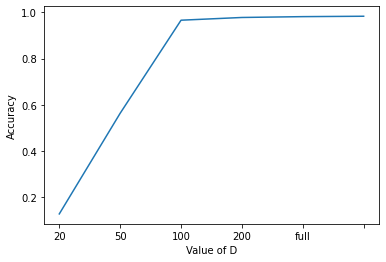

In [503]:
fig, axe = plt.subplots()
axe.plot(accuracy_list)
axe.set_ylabel("Accuracy")
axe.set_xlabel("Value of D")
d_value = [10,20, 50, 100, 200, 'full']
axe.set_xticklabels(d_value)
plt.show()

## **Part 2**

Creating the model architecture

In [ ]:
initializer = tf.keras.initializers.HeNormal()
model1 = Sequential()
model1.add(Dense(1024, input_dim=784,kernel_initializer=initializer))
model1.add(Activation('relu'))
model1.add(Dense(1024,kernel_initializer=initializer))
model1.add(Activation('relu'))
model1.add(Dense(1024,kernel_initializer=initializer))
model1.add(Activation('relu'))
model1.add(Dense(1024,kernel_initializer=initializer))
model1.add(Activation('relu'))
model1.add(Dense(1024,kernel_initializer=initializer))
model1.add(Activation('relu'))
model1.add(Dense(10))
model1.add(Activation('softmax'))

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              803840    
                                                                 
 activation_6 (Activation)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 activation_7 (Activation)   (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              1049600   
                                                                 
 activation_8 (Activation)   (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)             

**Here we initialize the weights of the above model1 to baseline svd weights with D=20 and we keep the bias as zero.**

In [ ]:
#ref: https://www.tensorflow.org/api_docs/python/tf/linalg/svd

for i in range(0,len(weights),2):
    s, u, v = tf.linalg.svd(weights[i])
    s = tf.linalg.diag(s)
    tf_weights_approx =  tf.matmul(tf.matmul(u[:,:20], s[:20,:20]), tf.transpose(v[:,:20]))
    if i == 10:
      model1.layers[i].set_weights([tf_weights_approx,tf.zeros([10,], dtype=tf.float32, name = None)])
    else:
      model1.layers[i].set_weights([tf_weights_approx,tf.zeros([1024,], dtype=tf.float32, name = None)])


**Compliling and running the model1 with the weights initialized as svd weights, after every epoch we get better results as compared to the normal output without back propogation.**

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model1.fit(xtrain,ytrain,epochs=15)

Epoch 1/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4421 - accuracy: 0.9425
Epoch 2/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1628 - accuracy: 0.9637
Epoch 3/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1304 - accuracy: 0.9684
Epoch 4/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1130 - accuracy: 0.9715
Epoch 5/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1007 - accuracy: 0.9736
Epoch 6/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0913 - accuracy: 0.9751
Epoch 7/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0838 - accuracy: 0.9766
Epoch 8/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0774 - accuracy: 0.9780
Epoch 9/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0722 - accuracy: 0.9789
Epoch 10/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.067

**Test accuracy for model1**

In [ ]:
model1.evaluate(xtest,ytest)

313/313 [==============================] - 1s 2ms/step - loss: 0.1253 - accuracy: 0.9764


[0.12531572580337524, 0.9764000177383423]

## **Part 3**

**In this we basically add a custom layer which compressed the weight matrix into a product of s,u and v with D as 20. Thus, each layer will convert the weights into a compressed version weights and we will use that for [inputs x svd(weights) + bias] calculation. Also, here since the gradient for compression is considered as identity function, we modify the gradient by calling the custom gradient function.**

In [3]:
#ref: https://www.tensorflow.org/guide/keras/custom_layers_and_models, https://www.tensorflow.org/api_docs/python/tf/custom_gradient
@tf.custom_gradient
def customize_function(weight):
    s, u, v = tf.linalg.svd(weight)
    s = tf.linalg.diag(s)
    W_hat =  tf.matmul(tf.matmul(u[:,:20], s[:20,:20]), tf.transpose(v[:,:20]))
    def grad(dy):
        gradient = dy
        return gradient
    return W_hat, grad

class Dense_New(Layer):

  def __init__(self, units,activation,weights,input_shape):
      super(Dense_New, self).__init__()
      self.units = units
      self.activation = tf.keras.activations.get(activation)
      w_init = weights
      self.w = tf.Variable(
          initial_value=w_init,trainable=True)
      b_init = tf.zeros_initializer()
      self.b = tf.Variable(
          initial_value=b_init(shape=(units,), dtype='float32'),trainable=True)

  def call(self, inputs):  # Defines the computation from inputs to outputs
      W_hat = customize_function(self.w)
      result = self.activation(tf.matmul(inputs, W_hat) + self.b)
      return result



**Creating the model architecture along with the custom layer defined above and weights intitalized from the baseline model.**

In [16]:

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(784,)),
    Dense_New(1024, activation='relu',weights=weights_baseline[0],input_shape=784),
    Dense_New(1024, activation='relu',weights=weights_baseline[2],input_shape=1024),
    Dense_New(1024, activation='relu',weights=weights_baseline[4],input_shape=1024),
    Dense_New(1024, activation='relu',weights=weights_baseline[6],input_shape=1024),
    Dense_New(1024, activation='relu',weights=weights_baseline[8],input_shape=1024),
    tf.keras.layers.Dense(10, activation='softmax')
])

**Compiling and running the model for the above model**

In [17]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
model2.fit(xtrain,ytrain,epochs=15,batch_size=512)

Epoch 1/15
118/118 [==============================] - 183s 2s/step - loss: 0.4937 - accuracy: 0.8855
Epoch 2/15
118/118 [==============================] - 178s 2s/step - loss: 0.0857 - accuracy: 0.9779
Epoch 3/15
118/118 [==============================] - 178s 2s/step - loss: 0.0671 - accuracy: 0.9808
Epoch 4/15
118/118 [==============================] - 178s 2s/step - loss: 0.0567 - accuracy: 0.9835
Epoch 5/15
118/118 [==============================] - 178s 2s/step - loss: 0.0529 - accuracy: 0.9840
Epoch 6/15
118/118 [==============================] - 177s 2s/step - loss: 0.0474 - accuracy: 0.9856
Epoch 7/15
118/118 [==============================] - 178s 2s/step - loss: 0.0474 - accuracy: 0.9854
Epoch 8/15
118/118 [==============================] - 177s 2s/step - loss: 0.0414 - accuracy: 0.9870
Epoch 9/15
118/118 [==============================] - 178s 2s/step - loss: 0.0431 - accuracy: 0.9868
Epoch 10/15
118/118 [==============================] - 177s 2s/step - loss: 0.0410 - accura

**Checking the test accuracy for the above model**

In [20]:
model2.evaluate(xtest,ytest,batch_size=64)

157/157 [==============================] - 237s 2s/step - loss: 0.1055 - accuracy: 0.9745


[0.10545135289430618, 0.9745000004768372]

## Part 4

**Loading the training and the test data**

In [369]:
with open('hw4_trs.pkl','rb') as train_file:
  train_df = pickle.load(train_file)
train_df.shape

(500, 16180)

In [370]:
with open('hw4_tes.pkl','rb') as test_file:
  test_df = pickle.load(test_file)
test_df.shape

(200, 22631)

**Making Negative Pair Samples**

In [371]:
def negative_pairs(positive_speaker_n, df, L=45):    
    i = positive_speaker_n *10
    j = i + 10  
    negative_speaker = df[:i] + df[j:]   
    positve_speaker = df[i:j]
    negative_samp = random.sample(negative_speaker, L)
    batch_pairs = []
        

    for x in range(L):
        positive_samp = random.choice(positve_speaker)
        stftp = np.abs(librosa.stft(positive_samp, n_fft=1024, hop_length=512)).T
        stftn = np.abs(librosa.stft(negative_samp[x], n_fft=1024, hop_length=512)).T
        batch_pairs.append([stftp, stftn])


    return batch_pairs

**Making Postive Pair Samples**

In [372]:
def positive_pairs(sp, L=45):
    total_pairs = list(combinations(range(10), 2))
    batch_pairs = []
    lis_pairs = random.sample(total_pairs, L)


    for x,y in lis_pairs:
        stft2 = np.abs(librosa.stft(sp[y], n_fft=1024, hop_length=512)).T
        stft1 = np.abs(librosa.stft(sp[x], n_fft=1024, hop_length=512)).T
        batch_pairs.append([stft1, stft2])

        
    return batch_pairs

**Making Training Batch Pairs**

In [381]:
batches_train = []
train_df = list(train_df)

for x in range(0,50):
  positive_bat = positive_pairs(train_df[x:x+10])
  negative_bat = negative_pairs(x,train_df)
  batches_train = batches_train + positive_bat + negative_bat

train_set = np.stack(batches_train)
train_set.shape

(4500, 2, 32, 513)

In [382]:
train_set[:,0].shape

(4500, 32, 513)

**Adding padding to make the shape similar to test**

In [383]:
train_set = np.pad(train_set, ((0,0), (0,0), (0, 13), (0,0)), mode = 'constant') 
train_set.shape

(4500, 2, 45, 513)

**Making Testing Batch Pairs**

In [384]:
batches_test = []
test_df = list(test_df)

for x in range(0,20):
  positive_bat = positive_pairs(test_df[x:x+10])
  negative_bat = negative_pairs(x,test_df)
  batches_test = batches_test + positive_bat + negative_bat

test_set = np.stack(batches_test)
test_set.shape

(1800, 2, 45, 513)

**Creating Actual Predictions for the positive/negative pairs**

In [385]:
target_train = [] 
for i in range(50):
    yact = np.zeros(90, dtype = int)
    yact[:45] += 1
    target_train.append(yact)
target_train = np.hstack(target_train)

In [386]:
target_test = [] 
for i in range(20):
    yact = np.zeros(90, dtype = int)
    yact[:45] += 1
    target_test.append(yact)
target_test = np.hstack(target_test)

**Creating the Siamese Model Architecture and Compiling the model**

Initially we create a GRU with one dense layer, then use two embeddings postive and negative samples and pass them as two inputs with the output as the multiplicate product of the two passed over a sigmoid activated dense layer.

In [455]:
#Ref: https://keras.io/examples/vision/siamese_network/
def siamese_model(input_shape):
    model3 = Sequential()
    model3.add(GRU(100, return_sequences = False,activation='tanh'))
    model3.add(Dense(30, activation = 'tanh'))

    postive_in = Input(input_shape)
    negative_in = Input(input_shape)
    postive_out = model3(postive_in)
    negative_out = model3(negative_in)

    pred = tf.multiply(postive_out, negative_out)
    #pred = tf.reshape(pred,[-1,1])
    pred_f = Dense(1,activation='sigmoid')(pred)


    siamese = Model(inputs = [postive_in,negative_in], outputs = pred_f)
    return siamese

In [456]:
final_model = siamese_model([None,513])

**Here the loss will be binary cross entropy or sigmoid cross entropy**

In [457]:
bce = tf.keras.losses.BinaryCrossentropy()

In [453]:
final_model.summary()

Model: "model_62"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_132 (InputLayer)         [(None, None, 513)]  0           []                               
                                                                                                  
 input_133 (InputLayer)         [(None, None, 513)]  0           []                               
                                                                                                  
 sequential_61 (Sequential)     (None, 30)           187530      ['input_132[0][0]',              
                                                                  'input_133[0][0]']              
                                                                                                  
 tf.math.multiply_61 (TFOpLambd  (None, 30)          0           ['sequential_61[0][0]',   

**Compiling and running the above siamese model**

In [458]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=bce,metrics=[BinaryAccuracy()])

In [459]:
final_model.fit([train_set[:, 0], train_set[:, 1]], target_train, batch_size=32, epochs=50)

Epoch 1/50
141/141 [==============================] - 5s 10ms/step - loss: 0.5128 - binary_accuracy: 0.7129
Epoch 2/50
141/141 [==============================] - 1s 10ms/step - loss: 0.1708 - binary_accuracy: 0.9527
Epoch 3/50
141/141 [==============================] - 1s 10ms/step - loss: 0.1138 - binary_accuracy: 0.9667
Epoch 4/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0681 - binary_accuracy: 0.9856
Epoch 5/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0543 - binary_accuracy: 0.9893
Epoch 6/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0628 - binary_accuracy: 0.9858
Epoch 7/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0510 - binary_accuracy: 0.9893
Epoch 8/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0356 - binary_accuracy: 0.9938
Epoch 9/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0349 - binary_accuracy: 0.9938
Epoch 10/50
141/141 [=======

**Predicting the accuracy and loss for the test set**

In [466]:
evaluate = final_model.evaluate([test_set[:, 0], test_set[:, 1]] ,target_test,batch_size=32,verbose=0)

In [471]:
accuracy = evaluate[1]
loss = evaluate[0]
print('Loss for test set: ',loss)
print('Accuracy for test set: ',accuracy)

Loss for test set:  0.28823373565674
Accuracy for test set:  0.7422345106964


In [ ]:
%%shell
jupyter nbconvert --to html /content/DL_Assignment3_Ajinkya.ipynb